# **Surprise**
## ** 1. 영화 추천 시스템 구성 **
sklearn 을 활용하여 추천시스템을 만든다

https://datascienceschool.net/view-notebook/fcd3550f11ac4537acec8d18136f2066/

In [1]:
# ! pip install surprise
# 영화 데이터 불러오기 [ 사용자, 영화, 평점 데이터 ]
import surprise
data = surprise.Dataset.load_builtin('ml-100k')

import pandas as pd
df = pd.DataFrame(data.raw_ratings, columns=["user", "item", "rate", "id"])
del df["id"]; print(df.shape); df.head(5)

(100000, 3)


,user,item,rate
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


In [2]:
# Pivot Table 로  평점 행렬(rate matrix) R 을 만든다
# y축 : 아이디("user") , x축 : 영화("item") 
df_table      = df.set_index(["user", "item"]).unstack()
df_table_temp = df_table.iloc[212:222, 808:817]
df_table_temp.fillna("")

rate                                
item  211 212 213 214 215 216 217 218 219
user                                     
290     3                   4       2    
291         4       4   4           4   4
292                 3                    
293     4       3       4   4   3   2    
294                                      
295             5       5   5   4   5    
296     4                                
297     4       3       2   4       3    
298     5       3       5                
299     4   4   5           5

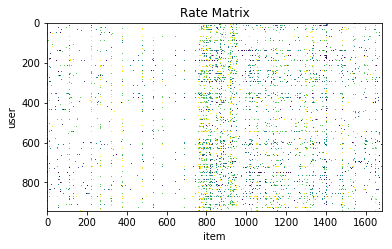

In [3]:
% matplotlib inline
# df_table 데이터 분포를 시각적 분석
import matplotlib.pyplot as plt
plt.imshow(df_table);     plt.grid(False)
plt.xlabel("item");       plt.ylabel("user")
plt.title("Rate Matrix"); plt.show()

<br>
## **2 추천 시스템 알고리즘 **
1. 베이스라인 모형
1. Collaborative Filtering
    1. Neighborhood Models
        1. User-based CF
        1. Item-based CF
    2. Latent Factor Models
        1. Matrix Factorization
        1. SVD
1. Content-Based Recommendation

<br>
### 1) **베이스라인 모형 (full coding) **
상품특성에 대한 평점 평균합을 통해서 결론을 도출

In [4]:
# n_folds = 데이터를 3개로 나눈다 (Train, Test, Valid)
import numpy as np
data.split(n_folds=3)

# 베이스라인 알고리즘 활용 (파라미터를 {dict}로 입력)
# ALS (Alternating Least Squares)의 인수 : 속도는 빠름
#     reg_i: 상품에 대한 정규화 가중치. 디폴트는 10.
#     reg_u: 사용자에 대한 정규화 가중치. 디폴트는 15.
#     n_epochs: 최적화 반복 횟수. 디폴트는 10.

# SGD (Stochastic Gradient Descent)의 인수 : 정확도가 높다 
#     reg: 정규화 가중치. 디폴트는 0.02.
#     learning_rate: 최적화 스텝 사이즈. 디폴트는 0.005.
#     n_epochs: 최적화 반복 횟수. 디폴트는 20.

bsl_options = {'method': 'als', 
               'reg_i': 5,     # item에 대한 정규화 가중치 (컬럼방향)
               'reg_u': 12,    # user에 대한 정규화 가중치 (row방향)
               'n_epochs': 5}  # epoch 반복횟수
algo = surprise.BaselineOnly(bsl_options = bsl_options)   
np.random.seed(0)
acc = np.zeros(3)

In [5]:
# Model 을 Train
for i, (trainset, testset) in enumerate(data.folds()):
    algo.fit(trainset)                                    # train 데이터 : 베이스라인 알고리즘 적용
    predictions = algo.test(testset)                      # test 데이터 : train 분석결과 예측 결과값 계산
    acc[i]      = surprise.accuracy.rmse(predictions,     
                                         verbose = True)  # RMSE 로 오차값 조정
acc.mean()

/home/markbaum/Python/django/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Estimating biases using als...
RMSE: 0.9463
Estimating biases using als...
RMSE: 0.9434
Estimating biases using als...
RMSE: 0.9411


0.9436222217133792

<br>
### 2) ** Neighborhood 모형 : 사용자나 상품 기준으로 평점의 유사성을 예측**
KNN 가중치 예측 방법

일단 유사도가 구해지면 평점을 예측하고자 하는 사용자(또는 상품)와 유사도가 큰 k개의 사용자(또는 상품) 벡터를 사용하여

가중 평균을 구해서 가중치를 예측한다. 이러한 방법을 KNN(K Nearest Neighbors) 기반 예측 방법이라고 한다.

surprise 패키지에서는 다음과 같은 3가지의 KNN 기반 가중치 예측 알고리즘 클래스를 제공한다.

In [6]:
# 1. 베이스라인 모형
# evaluate 명령을 사용하여 짧은 코딩 가능
data.split(n_folds = 3)
bsl_options = {'method': 'als', 
               'reg_i': 5, 
               'reg_u': 12, 
               'n_epochs': 5}
algo = surprise.BaselineOnly(bsl_options = bsl_options)
surprise.model_selection.cross_validate(algo, data)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'fit_time': (0.03055596351623535,
  0.04407382011413574,
  0.029871463775634766,
  0.03699135780334473,
  0.03518986701965332),
 'test_mae': array([0.74862385, 0.74907002, 0.74221837, 0.74399647, 0.74432726]),
 'test_rmse': array([0.94580024, 0.94658062, 0.93934563, 0.93798161, 0.93898959]),
 'test_time': (0.10895180702209473,
  0.13652825355529785,
  0.11638927459716797,
  0.11783528327941895,
  0.16123652458190918)}

In [7]:
# 피어슨 분류, cosine 분류 사용

# sim_options = {'name': 'msd'}      # Neighborhood 모형
# sim_options = {'name': 'cosine'}   # cosine 유사도 측정
sim_options = {'name': 'pearson'}    # 피어슨 유사도 측정
algo = surprise.KNNBasic(sim_options = sim_options)
surprise.model_selection.cross_validate(algo, data)

Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


{'fit_time': (2.5035247802734375,
  2.8520216941833496,
  2.436652183532715,
  2.475733995437622,
  1.6076571941375732),
 'test_mae': array([0.79776231, 0.80611373, 0.79766463, 0.8078662 , 0.80490979]),
 'test_rmse': array([1.00660627, 1.01624866, 1.00257394, 1.01626384, 1.01049223]),
 'test_time': (4.325087785720825,
  4.782121896743774,
  4.464331150054932,
  4.099863529205322,
  2.349487543106079)}

In [8]:
# 피어슨 분류모형 사용 2

sim_options = {'name': 'pearson_baseline'}
# algo = surprise.KNNBasic(sim_options=sim_options)
# algo = surprise.KNNBaseline(sim_options=sim_options)
algo = surprise.KNNWithMeans(sim_options=sim_options)
surprise.model_selection.cross_validate(algo, data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


{'fit_time': (1.5578079223632812,
  1.6644742488861084,
  2.1260242462158203,
  1.7243974208831787,
  1.0562875270843506),
 'test_mae': array([0.72247456, 0.72882343, 0.7305456 , 0.73145288, 0.73638026]),
 'test_rmse': array([0.92754729, 0.93637646, 0.93826381, 0.93812115, 0.94489859]),
 'test_time': (4.7007739543914795,
  4.618355751037598,
  4.283309459686279,
  4.562142610549927,
  2.4679455757141113)}

<br>
### 2) **Latent Factor 모형 : 행렬의 수치적 특징을 이용하여 유사성을 예측**
KNN 가중치 예측 방법 

In [9]:
algo = surprise.SVD(n_factors=200, n_epochs=30)
surprise.model_selection.cross_validate(algo, data)

{'fit_time': (17.251795291900635,
  17.519346952438354,
  18.47800064086914,
  16.940380334854126,
  10.170598983764648),
 'test_mae': array([0.74400909, 0.7494089 , 0.74190243, 0.74168499, 0.74591748]),
 'test_rmse': array([0.94554242, 0.94904958, 0.9427607 , 0.94188818, 0.94962578]),
 'test_time': (0.25911474227905273,
  0.2544386386871338,
  0.14855217933654785,
  0.2506260871887207,
  0.1941378116607666)}

In [10]:
algo = surprise.SVD(n_factors=200, n_epochs=30)
surprise.evaluate(algo, data)

/home/markbaum/Python/django/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/home/markbaum/Python/django/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9486
MAE:  0.7482
------------
Fold 2
RMSE: 0.9554
MAE:  0.7522
------------
Fold 3
RMSE: 0.9576
MAE:  0.7547
------------
------------
Mean RMSE: 0.9538
Mean MAE : 0.7517
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.7481998756918012,
                             0.7521644239480095,
                             0.7547219620556262],
                            'rmse': [0.9485734101308568,
                             0.9553809410801148,
                             0.957588923074147]})

<br>
# **잔재미 코딩**
## ** 1. 영화 추천데이터 불러오기 **
sklearn 을 활용하여 추천시스템을 만든다
1. https://datascienceschool.net/view-notebook/fcd3550f11ac4537acec8d18136f2066/
1. http://www.fun-coding.org/recommend_basic6.html

In [11]:
import numpy as np
from numpy import linalg as la
np.random.seed(42)

def flip_signs(A, B):  # http://stats.stackexchange.com/q/34396/115202
    signs = np.sign(A) * np.sign(B)
    return A, B * signs

# Let the data matrix X be of n x p size,
# where n is the number of samples and p is the number of variables
n, p = 5, 3
X = np.random.rand(n, p)
# Let us assume that it is centered
# 평균이 0으로 맞춘 후에 (centering 작업 수행) 공분산 행렬을 계산함
X -= np.mean(X, axis=0)

# the p x p covariance matrix
C = np.cov(X, rowvar=False)
print ("covariance matrix = \n", C)
# C is a symmetric matrix and so it can be diagonalized:
l, principal_axes = la.eig(C)
# sort results wrt. eigenvalues
idx = l.argsort()[::-1]
l, principal_axes = l[idx], principal_axes[:, idx]
# the eigenvalues in decreasing order
print ("eigenvalues = \n", l)
# a matrix of eigenvectors (each column is an eigenvector)
print ("eigenvectors = \n", principal_axes)
# projections of X on the principal axes are called principal components
principal_components = X.dot(principal_axes)
print ("principal_components = \n", principal_components)

# we now perform singular value decomposition of X
# "economy size" (or "thin") SVD
U, s, Vt = la.svd(X, full_matrices=False)
V = Vt.T
S = np.diag(s)

# 1) then columns of V are principal directions/axes.
print ("V = \n", V)
assert np.allclose(*flip_signs(V, principal_axes))

# 2) columns of US are principal components
print ("US = \n", U.dot(S))
assert np.allclose(*flip_signs(U.dot(S), principal_components))

# 3) singular values are related to the eigenvalues of covariance matrix
print ((s ** 2) / (n - 1))
assert np.allclose((s ** 2) / (n - 1), l)

# 8) dimensionality reduction
k = 2
PC_k = principal_components[:, 0:k]
US_k = U[:, 0:k].dot(S[0:k, 0:k])
print (US_k)
assert np.allclose(*flip_signs(PC_k, US_k))

print (U)
print (S)
print (V)
# 10) we used "economy size" (or "thin") SVD
assert U.shape == (n, p)
assert S.shape == (p, p)
assert V.shape == (p, p)

covariance matrix = 
 [[ 0.09338628 -0.11086559 -0.02943783]
 [-0.11086559  0.18770817  0.0336127 ]
 [-0.02943783  0.0336127   0.12511719]]
eigenvalues = 
 [0.27418905 0.11232653 0.01969604]
eigenvectors = 
 [[ 0.53435576  0.10510519 -0.83869948]
 [-0.79577968 -0.27194755 -0.54109078]
 [-0.28495372  0.95655498 -0.06167616]]
principal_components = 
 [[-0.5382821   0.04170504 -0.17101639]
 [ 0.37801268 -0.26959854  0.10654358]
 [-0.60281427 -0.09375913  0.14821045]
 [ 0.31232627  0.5572872   0.03786103]
 [ 0.45075742 -0.23563458 -0.12159868]]
V = 
 [[-0.53435576  0.10510519 -0.83869948]
 [ 0.79577968 -0.27194755 -0.54109078]
 [ 0.28495372  0.95655498 -0.06167616]]
US = 
 [[ 0.5382821   0.04170504 -0.17101639]
 [-0.37801268 -0.26959854  0.10654358]
 [ 0.60281427 -0.09375913  0.14821045]
 [-0.31232627  0.5572872   0.03786103]
 [-0.45075742 -0.23563458 -0.12159868]]
[0.27418905 0.11232653 0.01969604]
[[ 0.5382821   0.04170504]
 [-0.37801268 -0.26959854]
 [ 0.60281427 -0.09375913]
 [-0.31232

In [12]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
X = sparse_random_matrix(5, 5)
svd = TruncatedSVD(n_components=2, n_iter=7)  
U = svd.fit_transform(X)
Sigma = svd.explained_variance_ratio_
VT = svd.components_
svd.fit(X)
U

array([[ 5.95870798e-17,  2.79568523e-16],
       [ 8.19036259e-01,  3.69545189e-16],
       [-5.49686786e-17,  6.68740305e-01],
       [-4.12033416e-17,  6.68740305e-01],
       [ 8.19036259e-01, -1.36374889e-16]])

In [13]:
# https://medium.com/@ourpro.choi/%EC%B6%94%EC%B2%9C-%EC%97%94%EC%A7%84%EC%97%90-%EB%8C%80%ED%95%9C-%EA%B3%A0%EB%AF%BC-%EA%B3%B5%EB%B6%80%ED%96%88%EB%8D%98-%EB%82%B4%EC%9A%A9%EC%97%90-%EB%8C%80%ED%95%9C-%EC%A0%95%EB%A6%AC-%EB%82%B4%EC%9A%A9%EB%93%A4-edfe4c7b49fc